<a href="https://colab.research.google.com/github/abdelrahman-helal/planet-classification/blob/main/Planet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**About the Model**

I have built two neural network models and compared their performance in classifying images of the solar system planets.

**Dataset**

I used a public dataset collected and handled by Emirhan BULUT from https://github.com/emirhanai/Planets-and-Moons-Dataset-AI-in-Space



# Importing Libraries

In [140]:
import os
import pathlib
import random
import imghdr
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

# Accessing the Images and Checking their Format and Shape

In [139]:
data_dir = pathlib.Path('/content/drive/MyDrive/Planets_Moons_Data').with_suffix('')
imgs = list(data_dir.glob('*/*jpg'))
num_imgs = len(imgs)
print(f'There are {num_imgs} images in {len(list(os.listdir(data_dir)))} classes')


There are 1192 images in 8 classes


In [5]:
img_format = ['jpeg', 'png', 'bmp', 'gif'] # formats supported by tensorflow
non_imgs = []
for img in imgs:
  # looping over all images to check their format is supported by tensorflow
  if imghdr.what(img).lower() not in img_format:
    current_img = cv2.imread(str(img))
    cv2.imwrite(str(img)[:-3] + 'jpg', current_img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
print('All images are supported')


All images are supported


There are 149 images for Jupiter
Image 34 has a shape of (144, 256, 3)


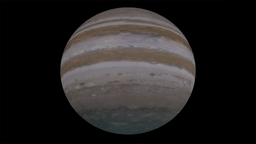

In [6]:
# Checking the number of images in the given planet class and showing a random image from that class
def planet(planet_name, directory):
  planet_dir = os.path.join(directory, planet_name)
  planet_imgs = os.listdir(planet_dir)
  print(f'There are {len(planet_imgs)} images for {planet_name}')

  random.seed(1)
  index = random.randint(0, len(planet_imgs))
  random_image = cv2.imread(str(os.path.join(planet_dir, planet_imgs[index])))
  print(f'Image {index} has a shape of {random_image.shape}')

  cv2_imshow(random_image)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

planet('Jupiter', data_dir)

In [7]:
# taking a 100 random images to check their shape as an indicative of the rest of the dataset
random.seed(2)
indices = random.sample(range(num_imgs), 100)
rand_imgs= []

for index in indices:
  rand_imgs.append(imgs[index])

imgs_shape = []
for i in rand_imgs:
  img = cv2.imread(str(i))
  imgs_shape.append(img.shape)


In [8]:
df = pd.DataFrame(imgs_shape, columns = ['Height', 'Width', 'Channels'])
df.describe()

,Height,Width,Channels
count,100.0,100.0,100.0
mean,144.0,256.0,3.0
std,0.0,0.0,0.0
min,144.0,256.0,3.0
25%,144.0,256.0,3.0
50%,144.0,256.0,3.0
75%,144.0,256.0,3.0
max,144.0,256.0,3.0


# Preparing Data

Since all the images have the same shape (144, 256, 3), this will be the image size in processing the data.

In [9]:
image_height = 144
image_width = 256
batch_size = 32

In [137]:
training_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split= 0.2,
    subset = 'training',
    seed = 123,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 1192 files belonging to 8 classes.
Using 954 files for training.


In [46]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split= 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 1192 files belonging to 8 classes.
Using 238 files for validation.


In [114]:
train_set = training_set.cache()
validation_set = validation_set.cache()

# Building the First Model

It consists of three dense layers (input layer, output layer, and one hidden layer) in addition to the Flatten and Rescaling layers as a preprocessing step and a dropout layer to reduce overfitting.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Rescaling(1./225),
    tf.keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(8, activation = 'linear')
])


In [135]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, None)              0         
                                                                 
 rescaling (Rescaling)       (None, None)              0         
                                                                 
 dense (Dense)               (None, 128)               14155904  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
Total params: 14,164,680
Trainable params: 14,164,680
No

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                            patience = 3,
                                            min_delta = 0.01)
# The model will do an early stopping if the validation loss does not improve by more than 0.01 for 3 epochs

In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [17]:
history_1 = model.fit(
    train_set,
    validation_data = validation_set,
    callbacks = [callback],
    epochs = 20
)

Epoch 1/20
30/30 [==============================] - 16s 456ms/step - loss: 5.0792 - accuracy: 0.4748 - val_loss: 0.6192 - val_accuracy: 0.7185
Epoch 2/20
30/30 [==============================] - 11s 362ms/step - loss: 0.6469 - accuracy: 0.8061 - val_loss: 0.4566 - val_accuracy: 0.8613
Epoch 3/20
30/30 [==============================] - 9s 300ms/step - loss: 0.3338 - accuracy: 0.8994 - val_loss: 0.0695 - val_accuracy: 0.9916
Epoch 4/20
30/30 [==============================] - 10s 330ms/step - loss: 0.1926 - accuracy: 0.9413 - val_loss: 0.0432 - val_accuracy: 0.9958
Epoch 5/20
30/30 [==============================] - 10s 354ms/step - loss: 0.1704 - accuracy: 0.9486 - val_loss: 0.0637 - val_accuracy: 0.9916
Epoch 6/20
30/30 [==============================] - 10s 324ms/step - loss: 0.1469 - accuracy: 0.9486 - val_loss: 0.0198 - val_accuracy: 0.9916
Epoch 7/20
30/30 [==============================] - 12s 397ms/step - loss: 0.1264 - accuracy: 0.9591 - val_loss: 0.0144 - val_accuracy: 1.0000


# Building the Second Model

This is a convolutional neural network that consists of two convolutional and maxpooling layers that then fully connect to two dense layers. The bath normalization and dropout are used to reduce overfitting.

In [18]:
model_conv  = tf.keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(8, activation = 'linear')
])

In [138]:
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 64)    1792      
                                                                 
 batch_normalization (BatchN  (None, None, None, 64)   256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 64)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 128)   73856     
                                                                 
 batch_normalization_1 (Batc  (None, None, None, 128)  512       
 hNormalization)                                                 
                                                      

In [19]:
model_conv.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [20]:
history_conv = model_conv.fit(
    train_set,
    validation_data = validation_set,
    callbacks = [callback],
    epochs = 20
)

Epoch 1/20
30/30 [==============================] - 248s 8s/step - loss: 15.2096 - accuracy: 0.8061 - val_loss: 57.1141 - val_accuracy: 0.6765
Epoch 2/20
30/30 [==============================] - 244s 8s/step - loss: 0.5447 - accuracy: 0.9769 - val_loss: 17.4014 - val_accuracy: 0.7227
Epoch 3/20
30/30 [==============================] - 240s 8s/step - loss: 0.2572 - accuracy: 0.9885 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/20
30/30 [==============================] - 239s 8s/step - loss: 0.0167 - accuracy: 0.9969 - val_loss: 1.6028e-08 - val_accuracy: 1.0000
Epoch 5/20
30/30 [==============================] - 241s 8s/step - loss: 0.0970 - accuracy: 0.9969 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
30/30 [==============================] - 245s 8s/step - loss: 0.0305 - accuracy: 0.9969 - val_loss: 5.0088e-10 - val_accuracy: 1.0000


# Comparing the Two Models

[Text(0.5, 23.52222222222222, 'epochs'),
 Text(313.26767676767673, 0.5, 'accuracy'),
 Text(0.5, 1.0, 'Validation Accuracy')]

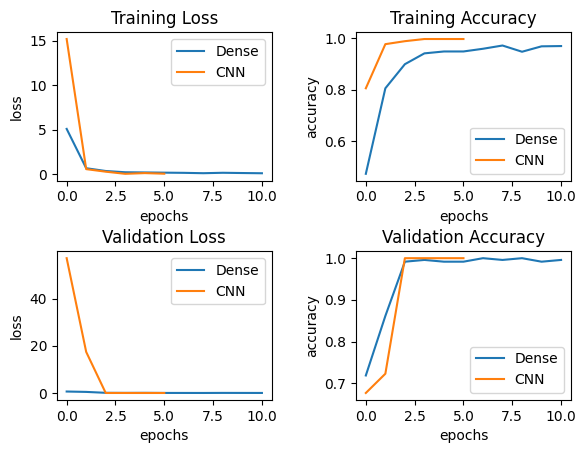

In [39]:
figure, axis = plt.subplots(2, 2)
figure.tight_layout(pad = 3.0)

axis[0, 0].plot(history_1.history['loss'], label = 'Dense')
axis[0, 0].plot(history_conv.history['loss'], label = 'CNN')
axis[0, 0].legend(fontsize="10")
axis[0, 0].set(xlabel = 'epochs', ylabel = 'loss', title = 'Training Loss')

axis[0, 1].plot(history_1.history['accuracy'], label = 'Dense')
axis[0, 1].plot(history_conv.history['accuracy'], label = 'CNN')
axis[0, 1].legend(fontsize="10")
axis[0, 1].set(xlabel = 'epochs', ylabel = 'accuracy', title = 'Training Accuracy')

axis[1, 0].plot(history_1.history['val_loss'], label = 'Dense')
axis[1, 0].plot(history_conv.history['val_loss'], label = 'CNN')
axis[1, 0].legend(fontsize="10")
axis[1, 0].set(xlabel = 'epochs', ylabel = 'loss', title = 'Validation Loss')

axis[1, 1].plot(history_1.history['val_accuracy'], label = 'Dense')
axis[1, 1].plot(history_conv.history['val_accuracy'], label = 'CNN')
axis[1, 1].legend(fontsize="10")
axis[1, 1].set(xlabel = 'epochs', ylabel = 'accuracy', title = 'Validation Accuracy')



While both models achieved a 100% validation accuracy, the CNN model converged in a fewer number of epochs and was more stable after convergence.

# Making Predictions

In [132]:
def prediction(model, image, full_data):
  img = tf.keras.utils.image_dataset_from_directory(image,
                                              image_size = (image_height, image_width),
                                              batch_size = 1,
                                              validation_split = 0
                                              )
  model_prediction = model.predict(img)
  propability = tf.nn.softmax(model_prediction)
  index = np.argmax(propability)
  return f'The planet is {full_data.class_names[index]}'




In [134]:
prediction(model, '/content/drive/MyDrive/Venus_Test', training_set)

Found 1 files belonging to 1 classes.
1/1 [==============================] - 0s 327ms/step


'The planet is Venus'

In [142]:
prediction(model, '/content/drive/MyDrive/Jupiter_Test', training_set)

Found 1 files belonging to 1 classes.
1/1 [==============================] - 0s 309ms/step


'The planet is Jupiter'